Import libaries

In [1]:
import pandas as pd
import numpy as np
import gensim, logging, nltk, re, string
from sklearn.linear_model import LogisticRegression

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Read data and drop NAs

In [4]:
tweets_train = pd.read_csv("data/train.csv", dtype=str, encoding='utf-8', sep=",", header=0, index_col=None, na_values='Not Available').dropna()
tweets_test = pd.read_csv("data/test.csv", dtype=str, encoding='utf-8', sep=",", header=0, index_col=None)
tweets_test.rename(columns = {'Category':'Tweet'}, inplace = True)

Plot number of tweets in each category

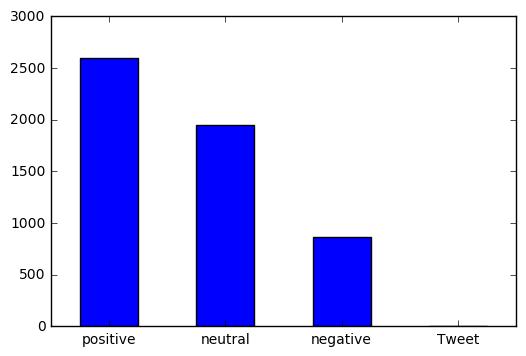

In [31]:
%matplotlib inline
tweets_train.Category.value_counts().plot(kind="bar", rot=0)

Tokenisation function and helpers

In [33]:
stopwords = ["a", "about", "after", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been",
            "before", "being", "between", "both", "by", "could", "did", "do", "does", "doing", "during", "each",
            "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here",
            "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've",
            "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "of",
            "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "own", "shan't", "she", "she'd",
            "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs",
            "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're",
            "they've", "this", "those", "through", "to", "until", "up", "very", "was", "wasn't", "we", "we'd",
            "we'll", "we're", "we've", "were", "weren't", "what", "what's", "when", "when's", "where", "where's",
            "which", "while", "who", "who's", "whom", "with", "would", "you", "you'd", "you'll", "you're", "you've",
            "your", "yours", "yourself", "yourselves", "above", "again", "against", "aren't", "below", "but", "can't",
            "cannot", "couldn't", "didn't", "doesn't", "don't", "down", "few", "hadn't", "hasn't", "haven't", "if",
            "isn't", "mustn't", "not", "no", "nor", "off", "out", "over", "shouldn't", "same", "too", "under", "why",
            "why's", "won't", "wouldn't"]

RE_HTTP = re.compile("http(s)?://[/\.a-z0-9]+")
RE_HASHTAG = re.compile("[@#][_a-z0-9]+")
RE_EMOTICONS = re.compile("(:-?\))|(:p)|(:d+)|(:-?\()|(:/)|(;-?\))|(<3)|(=\))|(\)-?:)|(:'\()|(8\))")

def prepare_text(text):
    replacers = {'&nbsp;': ' ', '&lt;': '<', '&gt;': '>', '&amp;': '&', '&pound;': u'£', 
                 '&euro;': u'€', '&copy;': u'©', '&reg;': u'®'}
    for r in replacers.keys():
        text = text.replace(r, replacers[r])
    return text

def contains_punctuation(text, translator):
    return (text.translate(translator) != text)
    
def tokenize_tweet(text):
    # replace broken characters
    text = prepare_text(text)
    #tokenize with tweet tokenizer
    tknz = nltk.tokenize.TweetTokenizer()
    tokens = tknz.tokenize(text.lower())
    # drop urls
    tokens = [token for token in tokens if not RE_HTTP.search(token)]
    # drop hashtags
    tokens = [token for token in tokens if not RE_HASHTAG.search(token)]
    # drop stopwords
    #tokens = [token for token in tokens if token not in stopwords]
    # drop punctuation (but not emoticons!)
    translator = str.maketrans('', '', string.punctuation)
    tokens = [token for token in tokens if RE_EMOTICONS.search(token) or not contains_punctuation(token, translator)]
    return tokens

Tokenize

In [34]:
train_tokenized = [tokenize_tweet(x) for x in tweets_train['Tweet'] if isinstance(x, str)]
test_tokenized = [tokenize_tweet(x) for x in tweets_test['Tweet'] if isinstance(x, str)]

In [35]:
print(train_tokenized[0:6])

[['ios', '9', 'app', 'transport', 'security', 'mm', 'need', 'to', 'check', 'if', 'my', '3rd', 'party', 'network', 'pod', 'supports', 'it'], ['mar', 'if', 'you', 'have', 'an', 'ios', 'device', 'you', 'should', 'download', 'our', 'app', 'too'], ['my', 'phone', 'does', 'not', 'run', 'on', 'latest', 'ios', 'which', 'may', 'account', 'for', 'problem', 'the', 'other', 'day', 'time', 'it', 'was', 'replaced'], ['not', 'sure', 'how', 'to', 'start', 'your', 'publication', 'on', 'ios', 'be', 'live', 'helping', 'with', 'ask', 'me', 'anything', 'sessions', 'today', 'and', 'friday'], ['two', 'dollar', 'tuesday', 'is', 'here', 'with', 'forklift', '2', 'quickkey', 'for', 'ios', 'and', 'suite', 'for', 'pages', 'for', 'just', 'today'], ['if', 'not', 'already', 'signed', 'up', 'to', 'test', 'my', 'ios', 'game', 'nows', 'your', 'chance']]


Create model

In [36]:
model = gensim.models.Word2Vec(train_tokenized, size=200, window=4, min_count=3, iter=30, workers=4)
model.init_sims(replace=True)

2017-01-19 15:51:23,987 : INFO : collecting all words and their counts
2017-01-19 15:51:23,989 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-01-19 15:51:24,037 : INFO : collected 10431 word types from a corpus of 97575 raw words and 5422 sentences
2017-01-19 15:51:24,041 : INFO : Loading a fresh vocabulary
2017-01-19 15:51:24,074 : INFO : min_count=3 retains 3183 unique words (30% of original 10431, drops 7248)
2017-01-19 15:51:24,075 : INFO : min_count=3 leaves 88817 word corpus (91% of original 97575, drops 8758)
2017-01-19 15:51:24,108 : INFO : deleting the raw counts dictionary of 10431 items
2017-01-19 15:51:24,109 : INFO : sample=0.001 downsamples 49 most-common words
2017-01-19 15:51:24,111 : INFO : downsampling leaves estimated 67877 word corpus (76.4% of prior 88817)
2017-01-19 15:51:24,114 : INFO : estimated required memory for 3183 words and 200 dimensions: 6684300 bytes
2017-01-19 15:51:24,133 : INFO : resetting layer weights
2017-01-19 15:

Count average word vector in tweet

In [37]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        return np.zeros(wv.layer_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, text) for text in text_list])

In [38]:
X_train_word_average = word_averaging_list(model.wv,train_tokenized)
X_test_word_average = word_averaging_list(model.wv,test_tokenized)

In [39]:
print(X_test_word_average)

[[-0.06783559 -0.07318275 -0.04694032 ..., -0.0491212  -0.01461332
   0.00671249]
 [-0.00764339 -0.09340752 -0.07280925 ..., -0.0804297  -0.01822649
  -0.00611928]
 [-0.04565764 -0.15492409 -0.17064734 ...,  0.06155074  0.09368764
   0.1140742 ]
 ..., 
 [ 0.02817192 -0.04598491 -0.00250292 ..., -0.04012828  0.01079136
  -0.00886637]
 [-0.04565764 -0.15492409 -0.17064734 ...,  0.06155074  0.09368764
   0.1140742 ]
 [ 0.02861984 -0.12866679 -0.09564702 ..., -0.10849581  0.03107977
  -0.0278804 ]]


Create classification model and predict

In [41]:
logreg = LogisticRegression(n_jobs=-1, C=1e4)

logreg = logreg.fit(X_train_word_average, tweets_train['Category'])
predicted = logreg.predict(X_test_word_average)

Export predicted values to CSV file

In [42]:
predicted_df = pd.DataFrame(predicted, columns=['Category'])
id_df = pd.DataFrame(tweets_test['Id'][0:len(test_tokenized)])
final = pd.concat([id_df, predicted_df], axis=1)
print(final)
final.to_csv(path_or_buf="data/my_submission.csv", sep=',', index=False)

                      Id  Category
0     628949369883000832  positive
1     628976607420645377  positive
2     629023169169518592  positive
3     629179223232479232  positive
4     629186282179153920   neutral
5     629226490152914944   neutral
6     629345637155360768  positive
7     629394528336637953  positive
8     629650766580609026  positive
9     629797991826722816   neutral
10    630159517058142208  positive
11    630542330827771904   neutral
12    630636736746422272  positive
13    630807124872970240  positive
14    630818265799921664  positive
15    630909171437801472  negative
16    630982270409572352   neutral
17    631104156187627520   neutral
18    631223085476261890  negative
19    631368262979297281   neutral
20    631521079245307904  positive
21    631543121407442946   neutral
22    631696872323850240  positive
23    631792365590695936  positive
24    631842974268305408  positive
25    631843393971204097  positive
26    631936716522278912   neutral
27    63237468333425

Following code was used to test accuracy on train data